# Contraband Data Investigation

Date: January 25, 2022

## Background

Mecklenburg County Sheriff’s Office recent policy changes:

* [Press Release](https://forwardjustice.org/meck-county-regulatory-stops/) from Forward Justice and Mecklenburg County Sheriff's Office announcing new policy to end regulatory traffic stops to minimize potentially harmful interactions between law enforcement and the community.
* Examples of regulatory offenses include financial responsibility violations (i.e. no insurance), vehicle inspections violations, certain driver’s license violations such as driving while license revoked, certain vehicle equipment violations such as improper mufflers, non-working head and rear lamps, window tinting, and a number of other non-moving violations enumerated in the policy
* Regulatory offenses cannot be the sole basis for a traffic stop. Deputies may charge a driver with regulatory offenses only after having stopped a vehicle for a more serious and/or potentially hazardous violation.
* "By eliminating traffic stops for these low-level infractions that do not contribute to public safety, we can begin to minimize unnecessary and potentially harmful interactions between law enforcement and communities and address the racial disparities clearly inherent in these stops."

## Goals

* Investigate department and officer contraband data to see how to potentially highlight and better visualize disparities related to regulatory stops and the race of the driver. If many regulatory stops occur that lead to searches, but don’t find contraband, then perhaps these stops aren’t really helping public safety.

## Questions
* How we might be able to use the data that we have and break it down more
* Does contraband correlate with type of stop?
* What percentage of stops did for contraband for each race
* Of those regulatory stops or equipment stops what kind of contraband are being found

In [4]:
import logging


def configure_root_logger():
    console_logger = logging.StreamHandler()
    console_logger.setLevel(logging.DEBUG)
    console_logger.setFormatter(
        logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    )

    logger = logging.getLogger()
    logger.handlers = []  # reset handlers in case this cell is re-run
    logger.setLevel(logging.DEBUG)
    logger.addHandler(console_logger)
    return logger

In [5]:
import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

In [6]:
import plotly
plotly.offline.init_notebook_mode()

In [7]:
logger = configure_root_logger()
pg_engine = create_engine("postgresql://postgres@db:5432/traffic_stops_nc")
pg_conn = pg_engine.connect()

# Data prep

## Agencies

In [8]:
def lookup_agencies(agency_names):
    return pd.read_sql(
        f"""
        SELECT
            id
            , name
        FROM nc_agency
        WHERE name ~ '{"|".join(agency_names)}'
        ORDER BY 2
        """,
        pg_conn,
    )

In [69]:
df = lookup_agencies({
    "Cary Police",
    "Durham",
    "Fayetteville Police", "Cumberland County",
    "Greensboro Police",
    "High Point Police", "Guilford County",
    "Mecklenburg",
    "Raleigh", "Wake County",
    "Winston-Salem Police", "Forsyth County",
    "Wilmington Police", "New Hanover County",
})
big_ten_ids = df['id'].tolist()
big_ten_ids.remove(284)
df

id                                     name
0    46                   Cary Police Department
1    52  Charlotte-Mecklenburg Police Department
2    69       Cumberland County Sheriff's Office
3    79           Durham County Sheriff's Office
4    80                 Durham Police Department
5    89           Fayetteville Police Department
6    92          Forsyth County Sheriff's Office
7   105             Greensboro Police Department
8   107         Guilford County Sheriff's Office
9   119             High Point Police Department
10  168      Mecklenburg County Sheriff's Office
11  199      New Hanover County Sheriff's Office
12  225                Raleigh Police Department
13  284         UNC Wilmington Police Department
14  290             Wake County Sheriff's Office
15  306             Wilmington Police Department
16  309          Winston-Salem Police Department

In [10]:
df = lookup_agencies({
    "Durham",
})
durham_ids = df['id'].tolist()
df

id                            name
0  79  Durham County Sheriff's Office
1  80        Durham Police Department

## Stop purpose groups

In [11]:
from enum import Enum

class StopPurpose(Enum):
    SPEED_LIMIT_VIOLATION         = 1   # Safety Violation
    STOP_LIGHT_SIGN_VIOLATION     = 2   # Safety Violation
    DRIVING_WHILE_IMPAIRED        = 3   # Safety Violation
    SAFE_MOVEMENT_VIOLATION       = 4   # Safety Violation
    VEHICLE_EQUIPMENT_VIOLATION   = 5   # Regulatory and Equipment
    VEHICLE_REGULATORY_VIOLATION  = 6   # Regulatory and Equipment
    OTHER_MOTOR_VEHICLE_VIOLATION = 9   # Regulatory and Equipment
    SEAT_BELT_VIOLATION           = 7   # Investigatory
    INVESTIGATION                 = 8   # Investigatory
    CHECKPOINT                    = 10  # Investigatory
    
    @classmethod
    def safety_violation(cls):
        return [cls.SPEED_LIMIT_VIOLATION.value, cls.STOP_LIGHT_SIGN_VIOLATION.value, cls.DRIVING_WHILE_IMPAIRED.value, cls.SAFE_MOVEMENT_VIOLATION.value]
    
    @classmethod
    def regulatory_equipment(cls):
        return [cls.VEHICLE_EQUIPMENT_VIOLATION.value, cls.VEHICLE_REGULATORY_VIOLATION.value, cls.OTHER_MOTOR_VEHICLE_VIOLATION.value]
    
    @classmethod
    def investigatory(cls):
        return [cls.SEAT_BELT_VIOLATION.value, cls.INVESTIGATION.value, cls.CHECKPOINT.value]
    
StopPurpose.regulatory_equipment()

[5, 6, 9]

# Search rate

In [12]:
df = pd.read_sql(
    f"""
    WITH stops AS (
        SELECT
            nc_stop.stop_id
            , nc_stop.agency_id
            , nc_stop.agency_description AS agency
            , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
                    WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
                    WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
                    ELSE 'Other'
               END) as stop_purpose_group
            , (nc_search.search_id IS NOT NULL) AS driver_searched
            , (CASE
                WHEN nc_contraband.contraband_id IS NULL THEN false
                ELSE true
                END) AS contraband_found
        FROM "nc_stop"
        INNER JOIN "nc_person"
            ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
        LEFT OUTER JOIN "nc_search"
            ON ("nc_stop"."stop_id" = "nc_search"."stop_id")
        LEFT OUTER JOIN "nc_contraband"
            ON ("nc_stop"."stop_id" = "nc_contraband"."stop_id")
        WHERE nc_stop.agency_id IN ({",".join(map(str, big_ten_ids))})
    )
    SELECT
        agency
        , stop_purpose_group
        , COUNT(*) AS stop_count
        , COUNT(*) FILTER (WHERE driver_searched = true) AS driver_searched
        , COUNT(*) FILTER (WHERE contraband_found = true) AS contraband_found
        --, COUNT(*) FILTER (WHERE driver_searched = true)::float / NULLIF(COUNT(*), 0) AS percent_stops_searched
        --, COUNT(*) FILTER (WHERE contraband_found = true) / NULLIF(COUNT(*) FILTER (WHERE driver_searched = true)::float, 0) AS contraband_hit_rate
    FROM stops
    GROUP BY 1, 2
    """,
    pg_conn,
)

## Statewide

In [24]:
state_df = pd.read_sql(
    f"""
    WITH stops AS (
        SELECT
            nc_stop.stop_id
            , nc_stop.agency_id
            , nc_stop.agency_description AS agency
            , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
                    WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
                    WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
                    ELSE 'Other'
               END) as stop_purpose_group
            , (nc_search.search_id IS NOT NULL) AS driver_searched
            , (CASE
                WHEN nc_contraband.contraband_id IS NULL THEN false
                ELSE true
                END) AS contraband_found
        FROM "nc_stop"
        INNER JOIN "nc_person"
            ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
        LEFT OUTER JOIN "nc_search"
            ON ("nc_stop"."stop_id" = "nc_search"."stop_id")
        LEFT OUTER JOIN "nc_contraband"
            ON ("nc_stop"."stop_id" = "nc_contraband"."stop_id")
    )
    SELECT
        stop_purpose_group
        , COUNT(*) AS stop_count
        , COUNT(*) FILTER (WHERE driver_searched = true) AS driver_searched
        , COUNT(*) FILTER (WHERE contraband_found = true) AS contraband_found
    FROM stops
    GROUP BY 1
    """,
    pg_conn,
)
state_df["percent_stops_searched"] = state_df.driver_searched / state_df.stop_count
state_df["contraband_hit_rate"] = state_df.contraband_found / state_df.driver_searched
state_df

stop_purpose_group  stop_count  driver_searched  contraband_found  \
0             Investigatory     4375183           163593             55798   
1  Regulatory and Equipment     8792163           374849            119973   
2          Safety Violation    15025810           332921             96208   

   percent_stops_searched  contraband_hit_rate  
0                0.037391             0.341078  
1                0.042634             0.320057  
2                0.022157             0.288981

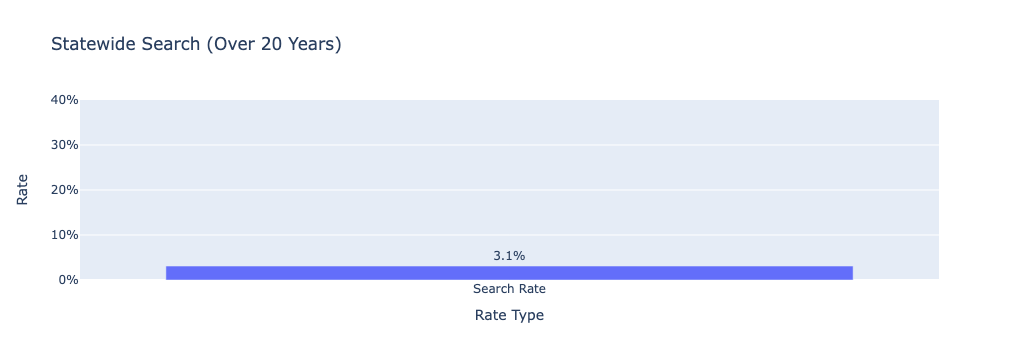

In [37]:
fig = px.bar(
    pd.DataFrame({
        "Rate Type": ["Search Rate"],
        "Rate": [state_df.driver_searched.sum() / state_df.stop_count.sum()],
    }),
    x="Rate Type",
    y='Rate',
    text='Rate',
    text_auto=',.1%',
    title="Statewide Search (Over 20 Years)",
    range_y=[0, .4],
)
fig.layout.yaxis.tickformat = ',.0%'
fig

/tmp/ipykernel_2029/2632770796.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



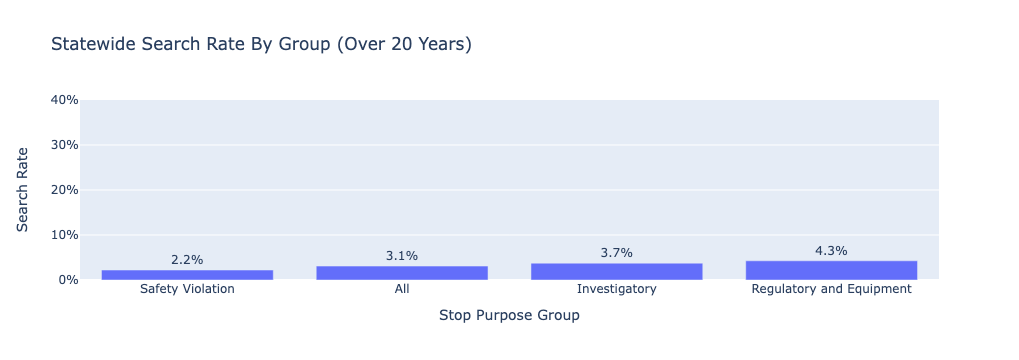

In [38]:
fig = px.bar(
    state_df.append({
                "stop_purpose_group": "All",
                "percent_stops_searched": state_df.driver_searched.sum() / state_df.stop_count.sum()
            }, ignore_index=True
        ).sort_values("percent_stops_searched"),
    x="stop_purpose_group",
    y='percent_stops_searched',
    text_auto=',.1%',
    labels={'percent_stops_searched': 'Search Rate', 'stop_purpose_group': 'Stop Purpose Group'},
    title="Statewide Search Rate By Group (Over 20 Years)",
    range_y=[0, .4],
)
fig.layout.yaxis.tickformat = ',.0%'
fig

## By department

In [29]:
df1 = df.groupby(["agency"], as_index=False).sum()
df1["percent_stops_searched"] = df1.driver_searched / df1.stop_count
df1["contraband_hit_rate"] = df1.contraband_found / df1.driver_searched
df1 = df1.sort_values("percent_stops_searched", ascending=False)
df1.style.format({
    'percent_stops_searched': '{:,.2%}'.format,
    'contraband_hit_rate': '{:,.2%}'.format,
}).set_caption("Big Ten: % Stops Searched and Contraband Hit Rate by Agency")

/tmp/ipykernel_2029/1470901560.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



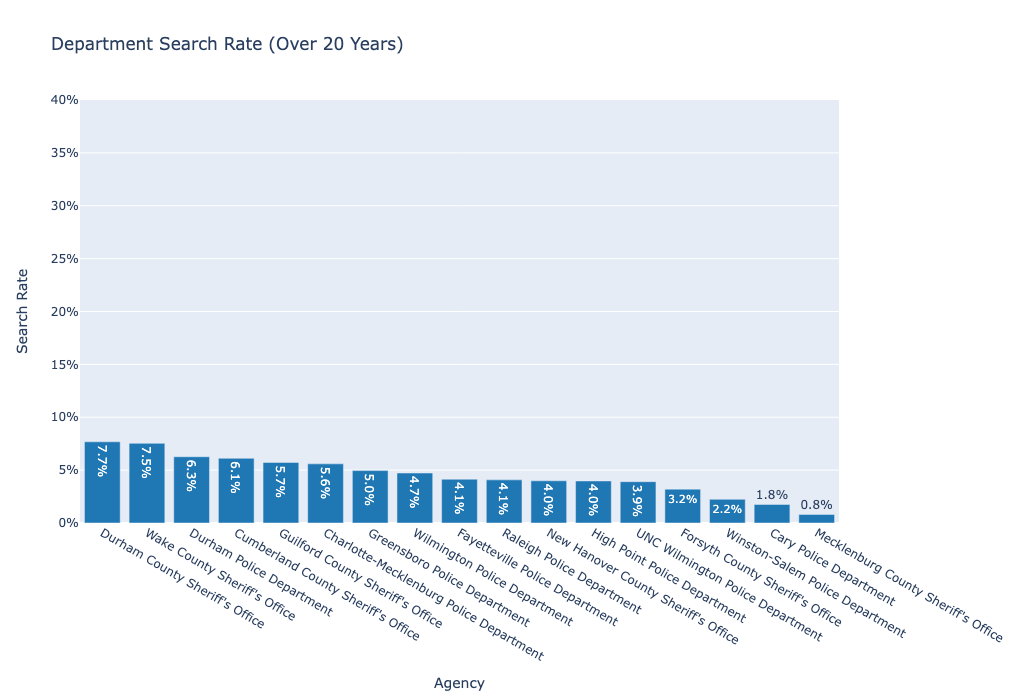

In [39]:
fig = px.bar(
    df1,
    x="agency",
    y='percent_stops_searched',
    # color="agency",
    text='percent_stops_searched',
    text_auto=',.1%',
    title="Department Search Rate (Over 20 Years)",
    labels={'percent_stops_searched':'Search Rate', 'agency':'Agency'},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=700,
    range_y=[0, .4],
)
fig.layout.yaxis.tickformat = ',.0%'
fig

### By stop group

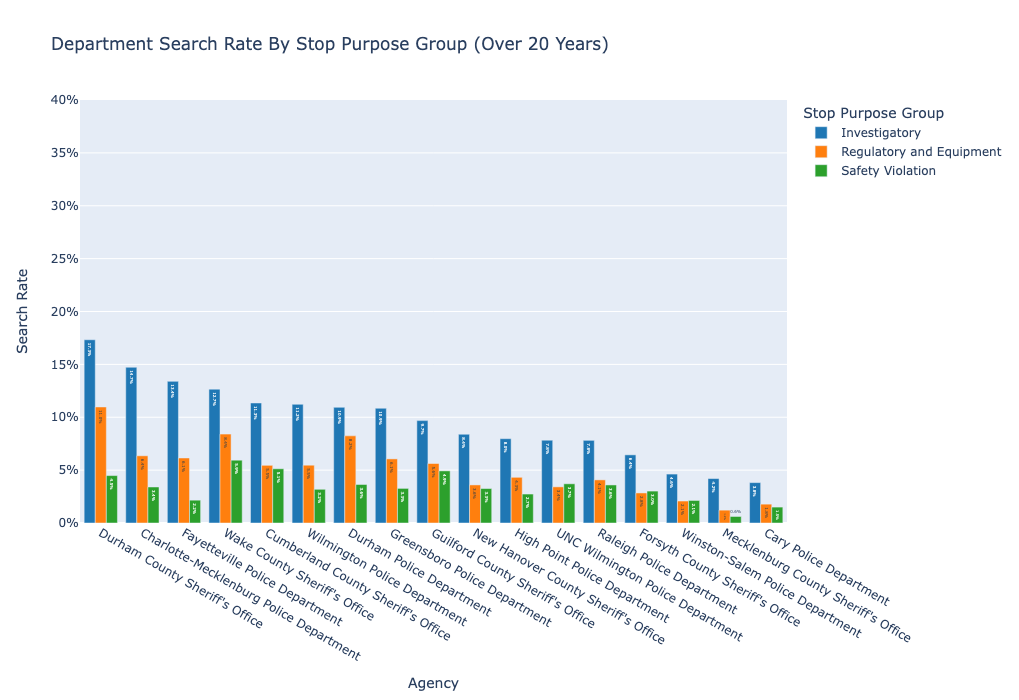

In [41]:
df2 = df.copy()
df2["percent_stops_searched"] = df2.driver_searched / df2.stop_count
df2["contraband_hit_rate"] = df2.contraband_found / df2.driver_searched
fig = px.bar(
    df2.sort_values(["percent_stops_searched", "stop_purpose_group"], ascending=False),
    x="agency",
    y='percent_stops_searched',
    color="stop_purpose_group",
    text='percent_stops_searched',
    text_auto=',.1%',
    title="Department Search Rate By Stop Purpose Group (Over 20 Years)",
    labels={'percent_stops_searched': 'Search Rate', 'agency':'Agency', "stop_purpose_group": "Stop Purpose Group"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=700,
    barmode="group",
    range_y=[0, .4],
)
fig.layout.yaxis.tickformat = ',.0%'
fig

# Contraband hit rate

## By department

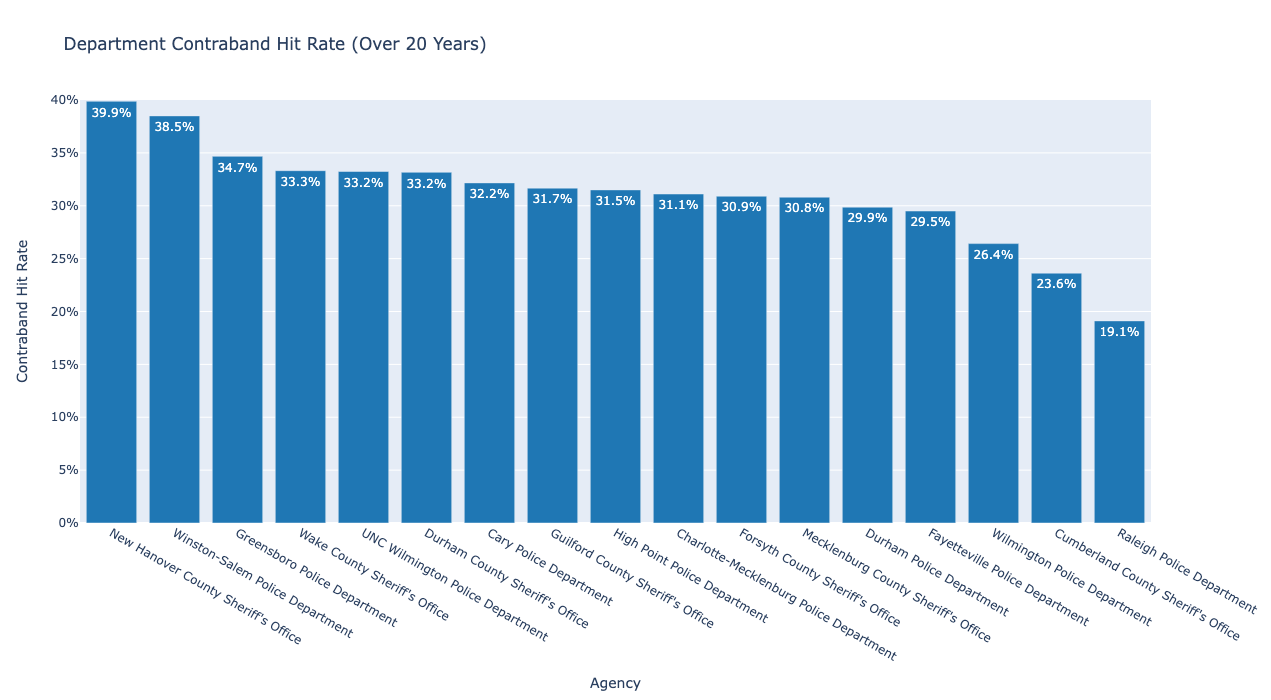

In [43]:
fig = px.bar(
    df1.sort_values("contraband_hit_rate", ascending=False),
    x="agency",
    y='contraband_hit_rate',
    # color="agency",
    text='contraband_hit_rate',
    text_auto=',.1%',
    title="Department Contraband Hit Rate (Over 20 Years)",
    labels={'contraband_hit_rate':'Contraband Hit Rate', 'agency':'Agency'},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=700,
    range_y=[0, .4],
)
fig.layout.yaxis.tickformat = ',.0%'
fig

## By stop group

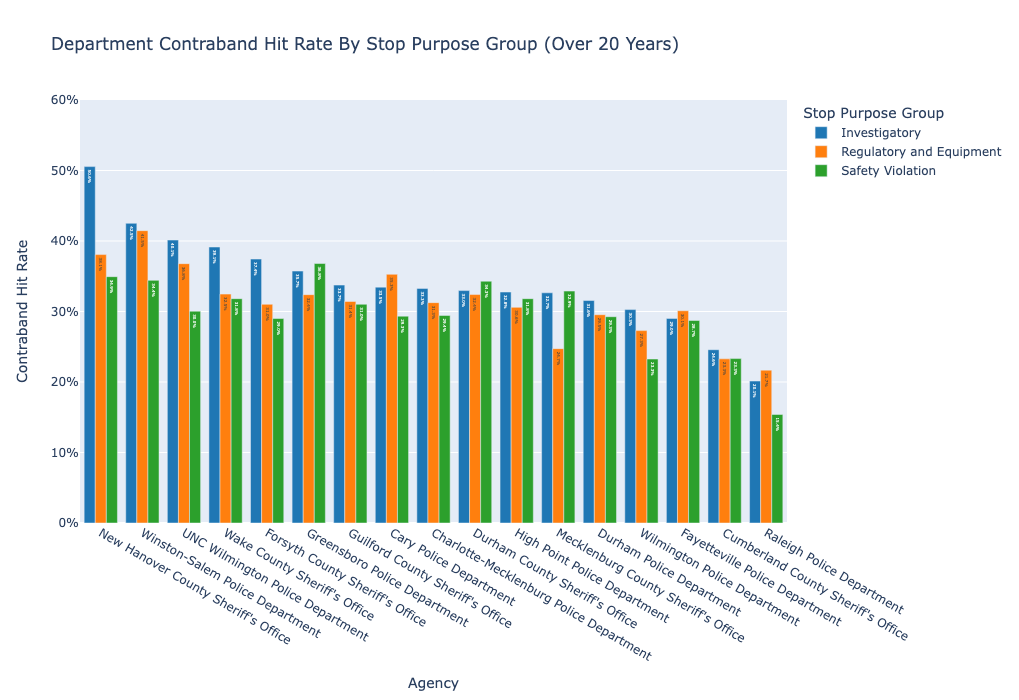

In [52]:
fig = px.bar(
    df2.sort_values(["contraband_hit_rate", "stop_purpose_group"], ascending=False),
    x="agency",
    y='contraband_hit_rate',
    color="stop_purpose_group",
    text='contraband_hit_rate',
    text_auto=',.1%',
    title="Department Contraband Hit Rate By Stop Purpose Group (Over 20 Years)",
    labels={'contraband_hit_rate': 'Contraband Hit Rate', 'agency':'Agency', "stop_purpose_group": "Stop Purpose Group"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=700,
    barmode="group",
    range_y=[0, .60],
)
fig.layout.yaxis.tickformat = ',.0%'
fig

# Race and Stop Group

In [71]:
df3 = pd.read_sql(
    f"""
    WITH stops AS (
        SELECT
            nc_stop.stop_id
            , nc_stop.agency_id
            , nc_stop.agency_description AS agency
            , (CASE WHEN nc_person.ethnicity = 'H' THEN 'Hispanic'
                    WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'A' THEN 'Asian'
                    WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'B' THEN 'Black'
                    WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'I' THEN 'Native American'
                    WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'U' THEN 'Other'
                    WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'W' THEN 'White'
               END) as driver_race
            , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
                    WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
                    WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
                    ELSE 'Other'
               END) as stop_purpose_group
            , (nc_search.search_id IS NOT NULL) AS driver_searched
            , (CASE
                WHEN nc_contraband.contraband_id IS NULL THEN false
                ELSE true
                END) AS contraband_found
        FROM "nc_stop"
        INNER JOIN "nc_person"
            ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
        LEFT OUTER JOIN "nc_search"
            ON ("nc_stop"."stop_id" = "nc_search"."stop_id")
        LEFT OUTER JOIN "nc_contraband"
            ON ("nc_stop"."stop_id" = "nc_contraband"."stop_id")
        WHERE nc_stop.agency_id IN ({",".join(map(str, big_ten_ids))})
    )
    SELECT
        agency
        , driver_race
        , stop_purpose_group
        , COUNT(*) AS stop_count
        , COUNT(*) FILTER (WHERE driver_searched = true) AS driver_searched
        , COUNT(*) FILTER (WHERE contraband_found = true) AS contraband_found
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_conn,
)

In [76]:
df3["percent_stops_searched"] = df3.driver_searched / df3.stop_count
df3["contraband_hit_rate"] = df3.contraband_found / df3.driver_searched
df4 = df3[df3["stop_purpose_group"] == "Regulatory and Equipment"]

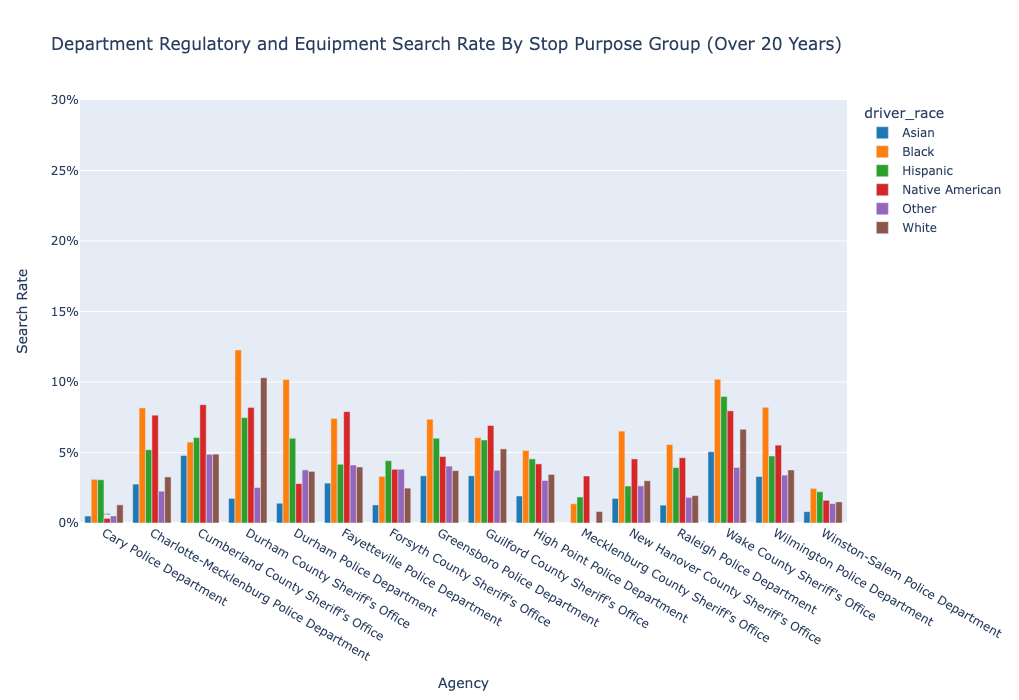

In [89]:
fig = px.bar(
    df4.sort_values(["agency", "stop_purpose_group"]),
    x="agency",
    y='percent_stops_searched',
    color="driver_race",
    text='percent_stops_searched',
    text_auto=',.1%',
    title="Department Regulatory and Equipment Search Rate By Stop Purpose Group (Over 20 Years)",
    labels={'percent_stops_searched': 'Search Rate', 'agency':'Agency', "stop_purpose_group": "Stop Purpose Group"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=700,
    barmode="group",
    range_y=[0, .30],
)
fig.layout.yaxis.tickformat = ',.0%'
fig

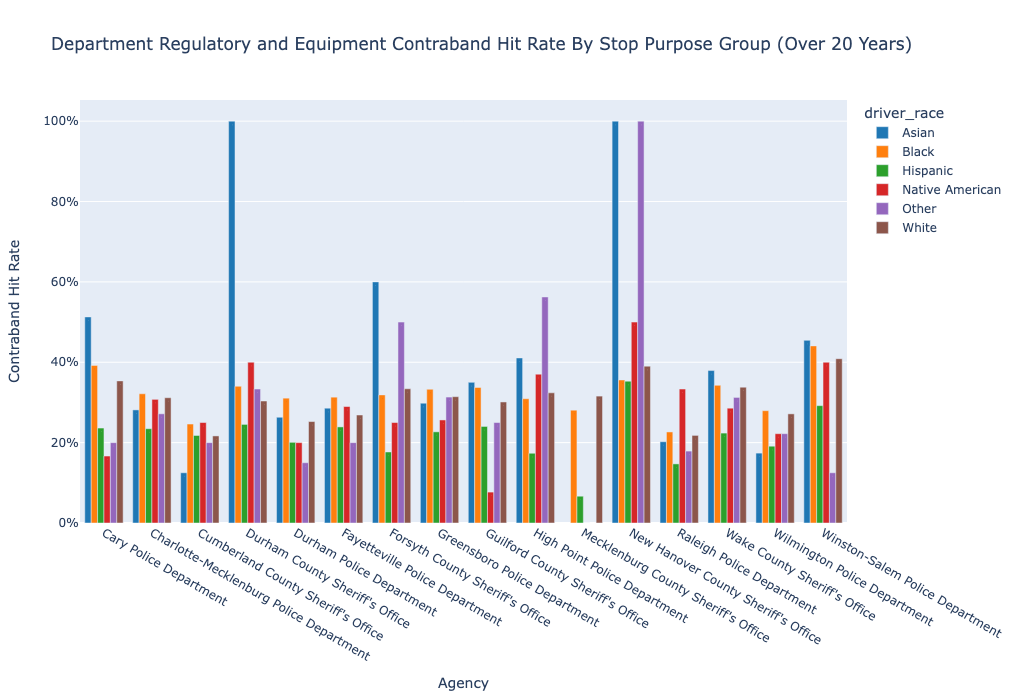

In [87]:
fig = px.bar(
    df4.sort_values(["agency"]),
    x="agency",
    y='contraband_hit_rate',
    color="driver_race",
    text='contraband_hit_rate',
    text_auto=',.1%',
    title="Department Regulatory and Equipment Contraband Hit Rate By Stop Purpose Group (Over 20 Years)",
    labels={'contraband_hit_rate': 'Contraband Hit Rate', 'agency':'Agency', "stop_purpose_group": "Stop Purpose Group"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=700,
    barmode="group",
)
fig.layout.yaxis.tickformat = ',.0%'
fig

In [98]:
fayetteville = df4[df4["agency"].isin(["Fayetteville Police Department"])]
fayetteville

agency      driver_race  \
91   Fayetteville Police Department            Asian   
94   Fayetteville Police Department            Black   
97   Fayetteville Police Department         Hispanic   
100  Fayetteville Police Department  Native American   
103  Fayetteville Police Department            Other   
106  Fayetteville Police Department            White   

           stop_purpose_group  stop_count  driver_searched  contraband_found  \
91   Regulatory and Equipment        2476               70                20   
94   Regulatory and Equipment      161578            11982              3752   
97   Regulatory and Equipment       13245              552               132   
100  Regulatory and Equipment        2620              207                60   
103  Regulatory and Equipment        1337               55                11   
106  Regulatory and Equipment       79231             3148               846   

     percent_stops_searched  contraband_hit_rate  
91                 0.028271             0.285714  
94                 0.074156             0.313136  
97                 0.041676             0.239130  
100                0.079008             0.289855  
103                0.041137             0.200000  
106                0.039732             0.268742

In [100]:
fayetteville.melt(id_vars=["driver_race"], value_vars=["percent_stops_searched", "contraband_hit_rate"])

driver_race                variable     value
0             Asian  percent_stops_searched  0.028271
1             Black  percent_stops_searched  0.074156
2          Hispanic  percent_stops_searched  0.041676
3   Native American  percent_stops_searched  0.079008
4             Other  percent_stops_searched  0.041137
5             White  percent_stops_searched  0.039732
6             Asian     contraband_hit_rate  0.285714
7             Black     contraband_hit_rate  0.313136
8          Hispanic     contraband_hit_rate  0.239130
9   Native American     contraband_hit_rate  0.289855
10            Other     contraband_hit_rate  0.200000
11            White     contraband_hit_rate  0.268742

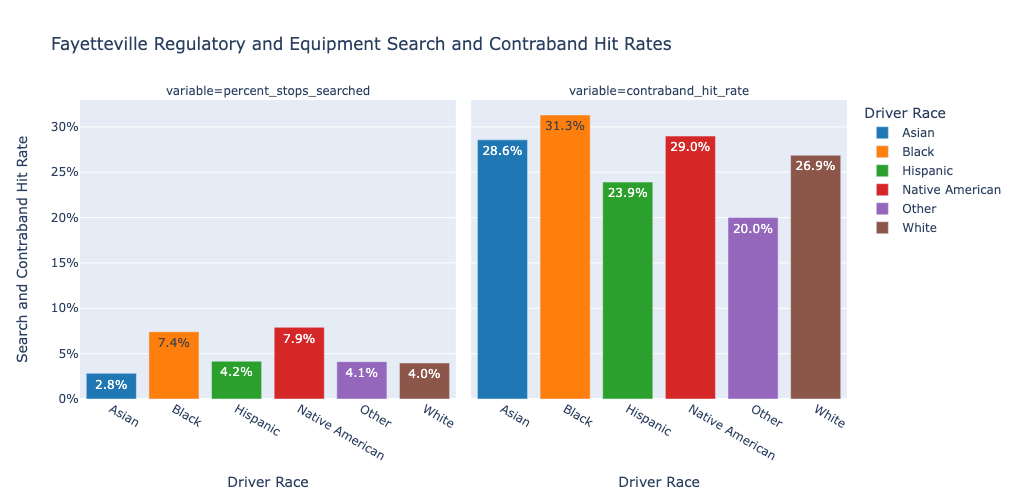

In [114]:

fig = px.bar(
    fayetteville.melt(id_vars=["driver_race"], value_vars=["percent_stops_searched", "contraband_hit_rate"]),
    x="driver_race",
    y='value',
    color="driver_race",
    text='value',
    text_auto=',.1%',
    title="Fayetteville Regulatory and Equipment Search and Contraband Hit Rates",
    labels={'value': 'Search and Contraband Hit Rate', "driver_race": "Driver Race"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=500,
    facet_col="variable"
)
fig.layout.yaxis.tickformat = ',.0%'
fig

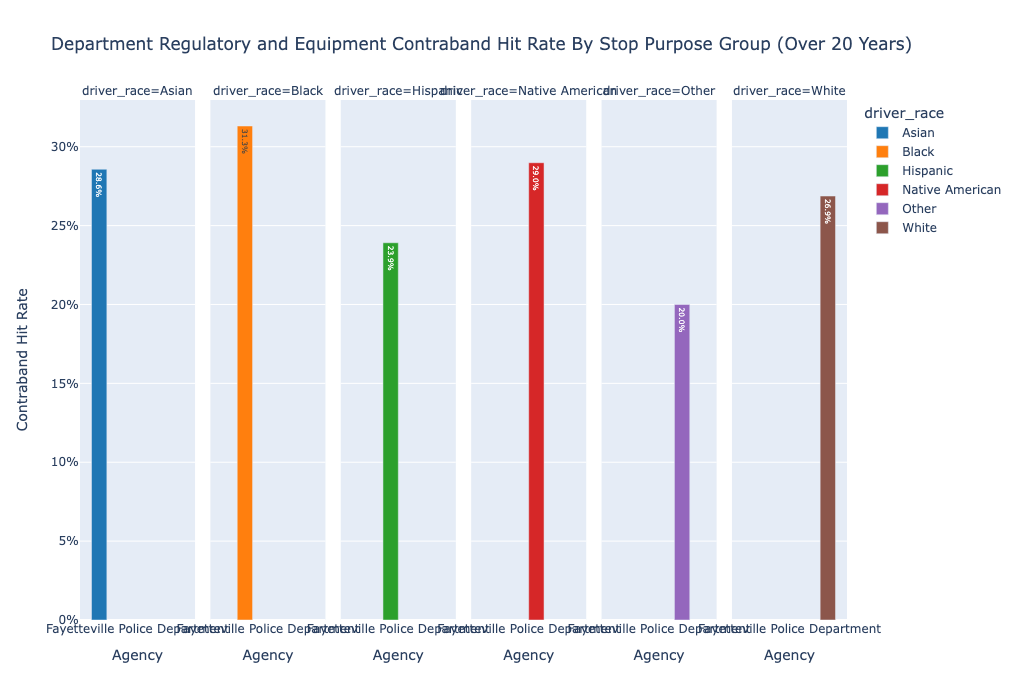

In [96]:

fig = px.bar(
    df4[df4["agency"].isin(["Fayetteville Police Department"])],
    x="agency",
    y='contraband_hit_rate',
    color="driver_race",
    text='contraband_hit_rate',
    text_auto=',.1%',
    title="Department Regulatory and Equipment Contraband Hit Rate By Stop Purpose Group (Over 20 Years)",
    labels={'contraband_hit_rate': 'Contraband Hit Rate', 'agency':'Agency', "stop_purpose_group": "Stop Purpose Group"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=700,
    barmode="group",
    facet_col="driver_race",
)
fig.layout.yaxis.tickformat = ',.0%'
fig